In [1]:
import pandas as pd

# Load the datasets
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
dev_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv'
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'

# Load TSV files into DataFrames
train_data = pd.read_csv(train_file_path, sep='\t')
dev_data = pd.read_csv(dev_file_path, sep='\t')
test_data = pd.read_csv(test_file_path, sep='\t')

# Display the first few rows of each dataset
train_data.head(), dev_data.head(), test_data.head()

(             event_name            tweet_id              image_id  \
 0  california_wildfires  917791291823591425  917791291823591425_0   
 1  california_wildfires  917791291823591425  917791291823591425_1   
 2  california_wildfires  917793137925459968  917793137925459968_0   
 3  california_wildfires  917793137925459968  917793137925459968_1   
 4  california_wildfires  917793137925459968  917793137925459968_2   
 
                                           tweet_text  \
 0  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 1  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 2  RT @KAKEnews: California wildfires destroy mor...   
 3  RT @KAKEnews: California wildfires destroy mor...   
 4  RT @KAKEnews: California wildfires destroy mor...   
 
                                                image            label  \
 0  data_image/california_wildfires/10_10_2017/917...      informative   
 1  data_image/california_wildfires/10_10_2017/917...  not_informative   
 2  data_ima

c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Epoch 1: Training Multimodal (gated fusion) head on positive label_text_image samples


Epoch 1 Training:  96%|█████████▌| 813/851 [33:52<01:37,  2.57s/it]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1 Training: 100%|██████████| 851/851 [35:35<00:00,  2.51s/it]


Training Loss: 0.0114 | Training Accuracy: 0.9993


Epoch 1 Validation: 100%|██████████| 140/140 [01:23<00:00,  1.67it/s]


Validation Loss: 0.0003 | Validation Accuracy: 1.0000

Epoch 2: Training Text-only head on full data


Epoch 2 Training: 100%|██████████| 851/851 [38:18<00:00,  2.70s/it]  


Training Loss: 0.4891 | Training Accuracy: 0.7828


Epoch 2 Validation: 100%|██████████| 140/140 [03:35<00:00,  1.54s/it]


Validation Loss: 0.4587 | Validation Accuracy: 0.8243

Epoch 3: Training Image-only head on full data


Epoch 3 Training: 100%|██████████| 851/851 [1:46:49<00:00,  7.53s/it]


Training Loss: 0.4205 | Training Accuracy: 0.8033


Epoch 3 Validation: 100%|██████████| 140/140 [04:17<00:00,  1.84s/it]


Validation Loss: 0.3513 | Validation Accuracy: 0.8538

Epoch 4: Training Multimodal (gated fusion) head on positive label_text_image samples


Epoch 4 Training: 100%|██████████| 851/851 [51:16<00:00,  3.61s/it] 


Training Loss: 0.0036 | Training Accuracy: 1.0000


Epoch 4 Validation: 100%|██████████| 140/140 [01:42<00:00,  1.37it/s]


Validation Loss: 0.0004 | Validation Accuracy: 1.0000

Epoch 5: Training Text-only head on full data


Epoch 5 Training: 100%|██████████| 851/851 [46:32<00:00,  3.28s/it] 


Training Loss: 0.3613 | Training Accuracy: 0.8548


Epoch 5 Validation: 100%|██████████| 140/140 [03:34<00:00,  1.53s/it]


Validation Loss: 0.4068 | Validation Accuracy: 0.8301

Epoch 6: Training Image-only head on full data


Epoch 6 Training: 100%|██████████| 851/851 [1:55:59<00:00,  8.18s/it]


Training Loss: 0.2387 | Training Accuracy: 0.9010


Epoch 6 Validation: 100%|██████████| 140/140 [04:21<00:00,  1.87s/it]

Validation Loss: 0.4061 | Validation Accuracy: 0.8467


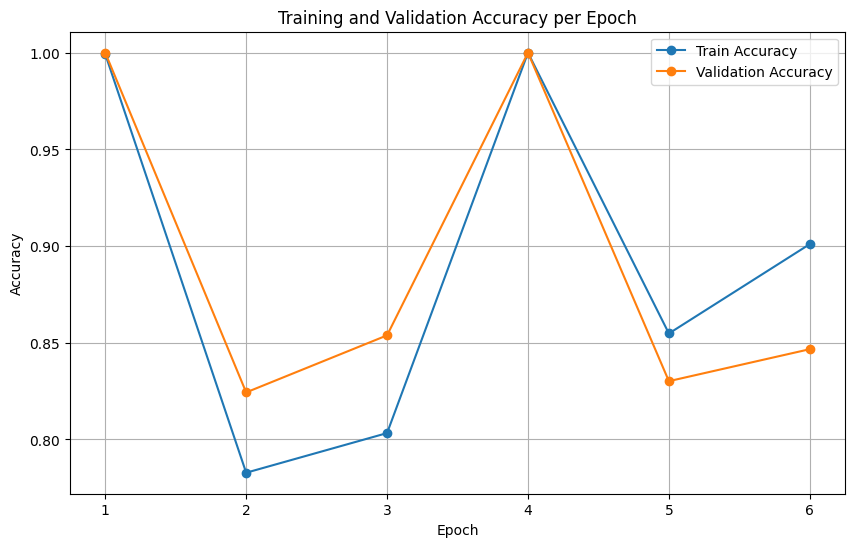

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, ViTModel
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Dataset and Preprocessing ---

class CrisisDataset(Dataset):
    def __init__(self, dataframe, tokenizer, image_transform):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # Tokenize tweet text (using a max length of 128 tokens)
        encoding = self.tokenizer(
            row['tweet_text'],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()       # (max_length,)
        attention_mask = encoding['attention_mask'].squeeze()  # (max_length,)

        # Load image (assuming the path stored in the dataframe is valid)
        image_path = row['image']
        image = Image.open(image_path).convert("RGB")
        image = self.image_transform(image)

        # Convert string labels to binary.
        # For the text-only and image-only branches we use:
        label = 1.0 if row['label'] == "informative" else 0.0
        label_text = 1.0 if row['label_text'] == "informative" else 0.0
        label_image = 1.0 if row['label_image'] == "informative" else 0.0
        # For the multimodal head we use label_text_image, but we will train only on positives.
        label_text_image = 1.0 if row['label_text_image'] == "Positive" else 0.0

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label, dtype=torch.float),
            'label_text': torch.tensor(label_text, dtype=torch.float),
            'label_image': torch.tensor(label_image, dtype=torch.float),
            'label_text_image': torch.tensor(label_text_image, dtype=torch.float)
        }

# Define image transformations for ViT (resize, normalization, etc.)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Example normalization; adjust mean and std as needed for your pretrained ViT model
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load your CSV/TSV files (adjust file paths as needed)
train_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv', sep='\t')
dev_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv', sep='\t')

# Create dataset and dataloaders
train_dataset = CrisisDataset(train_df, tokenizer, image_transform)
dev_dataset = CrisisDataset(dev_df, tokenizer, image_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False)

# --- Model Definition with Gated Fusion for Multimodal Branch ---

class MultimodalClassifier(nn.Module):
    def __init__(self):
        super(MultimodalClassifier, self).__init__()
        # Load pretrained encoders for text and image.
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        # Use a pretrained ViT; note that "google/vit-base-patch16-224-in21k" outputs 768-dim embeddings.
        self.image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        
        # Both models output embeddings of size 768 so that they share a common space.
        hidden_size = self.text_encoder.config.hidden_size
        
        self.dropout = nn.Dropout(0.1)
        # --- Multimodal branch using gated fusion ---
        self.gate_layer = nn.Linear(hidden_size, hidden_size)
        self.classifier = nn.Linear(hidden_size, 1)
        
        # --- Individual modality heads ---
        self.text_head = nn.Linear(hidden_size, 1)
        self.image_head = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask, image):
        # Text encoding
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeds = text_outputs.pooler_output  # shape: (batch, hidden_size)
        
        # Image encoding
        image_outputs = self.image_encoder(pixel_values=image)
        image_embeds = image_outputs.pooler_output  # shape: (batch, hidden_size)
        
        # --- Gated fusion for multimodal representation ---
        gate = torch.sigmoid(self.gate_layer(text_embeds + image_embeds))  # (batch, hidden_size)
        fused = gate * text_embeds + (1 - gate) * image_embeds  # (batch, hidden_size)
        multimodal_logits = self.classifier(self.dropout(fused))
        
        # Text-only and image-only branches
        text_logits = self.text_head(self.dropout(text_embeds))
        image_logits = self.image_head(self.dropout(image_embeds))
        
        return multimodal_logits, text_logits, image_logits

# --- Training Setup ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# Simple function to compute binary accuracy
def compute_accuracy(logits, labels):
    preds = (torch.sigmoid(logits) > 0.5).float()
    correct = (preds == labels.unsqueeze(1)).sum().item()
    return correct / labels.size(0)

# Lists to track accuracies per epoch for plotting
train_acc_history = []
val_acc_history = []
  
# --- Training Loop ---
# We train for 6 epochs total (2 epochs per head: multimodal, text, and image).
num_cycles = 2  # 2 cycles (2 epochs per head)
total_epochs = num_cycles * 3  # 6 epochs total

for epoch in range(total_epochs):
    # Decide which branch to train in the current epoch.
    if epoch % 3 == 0:
        current_head = "multimodal"
        print(f"\nEpoch {epoch+1}: Training Multimodal (gated fusion) head on positive label_text_image samples")
    elif epoch % 3 == 1:
        current_head = "text"
        print(f"\nEpoch {epoch+1}: Training Text-only head on full data")
    else:
        current_head = "image"
        print(f"\nEpoch {epoch+1}: Training Image-only head on full data")
    
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        
        # For the multimodal branch, filter for only positive label_text_image samples.
        if current_head == "multimodal":
            label_text_image = batch['label_text_image'].to(device)
            mask = label_text_image == 1.0
            if mask.sum().item() == 0:
                continue  # Skip if no positive samples in this batch
            input_ids = input_ids[mask]
            attention_mask = attention_mask[mask]
            images = images[mask]
            # For training multimodal head, we use a positive target (1.0) for every sample.
            targets = torch.ones(mask.sum().item(), device=device)
        elif current_head == "text":
            targets = batch['label_text'].to(device)
        else:
            targets = batch['label_image'].to(device)
        
        multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
        
        if current_head == "multimodal":
            logits = multimodal_logits
        elif current_head == "text":
            logits = text_logits
        else:
            logits = image_logits
        
        loss = criterion(logits, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        batch_size = input_ids.size(0)
        running_loss += loss.item() * batch_size
        running_corrects += compute_accuracy(logits, targets) * batch_size
        total_samples += batch_size
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    print(f"Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.4f}")
    train_acc_history.append(epoch_acc)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(dev_loader, desc=f"Epoch {epoch+1} Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            
            # For validation, if training multimodal head, use only the positive samples.
            if current_head == "multimodal":
                label_text_image = batch['label_text_image'].to(device)
                mask = label_text_image == 1.0
                if mask.sum().item() == 0:
                    continue  # Skip if no positive samples in the batch
                input_ids = input_ids[mask]
                attention_mask = attention_mask[mask]
                images = images[mask]
                targets = torch.ones(mask.sum().item(), device=device)
            elif current_head == "text":
                targets = batch['label_text'].to(device)
            else:
                targets = batch['label_image'].to(device)
            
            multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
            
            if current_head == "multimodal":
                logits = multimodal_logits
            elif current_head == "text":
                logits = text_logits
            else:
                logits = image_logits
            
            loss = criterion(logits, targets.unsqueeze(1))
            batch_size = input_ids.size(0)
            val_loss += loss.item() * batch_size
            val_corrects += compute_accuracy(logits, targets) * batch_size
            val_samples += batch_size

    if val_samples > 0:
        val_epoch_loss = val_loss / val_samples
        val_epoch_acc = val_corrects / val_samples
    else:
        val_epoch_loss = 0.0
        val_epoch_acc = 0.0
    print(f"Validation Loss: {val_epoch_loss:.4f} | Validation Accuracy: {val_epoch_acc:.4f}")
    val_acc_history.append(val_epoch_acc)

# --- Plotting Accuracy History ---

epochs = list(range(1, total_epochs + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_history, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc_history, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()


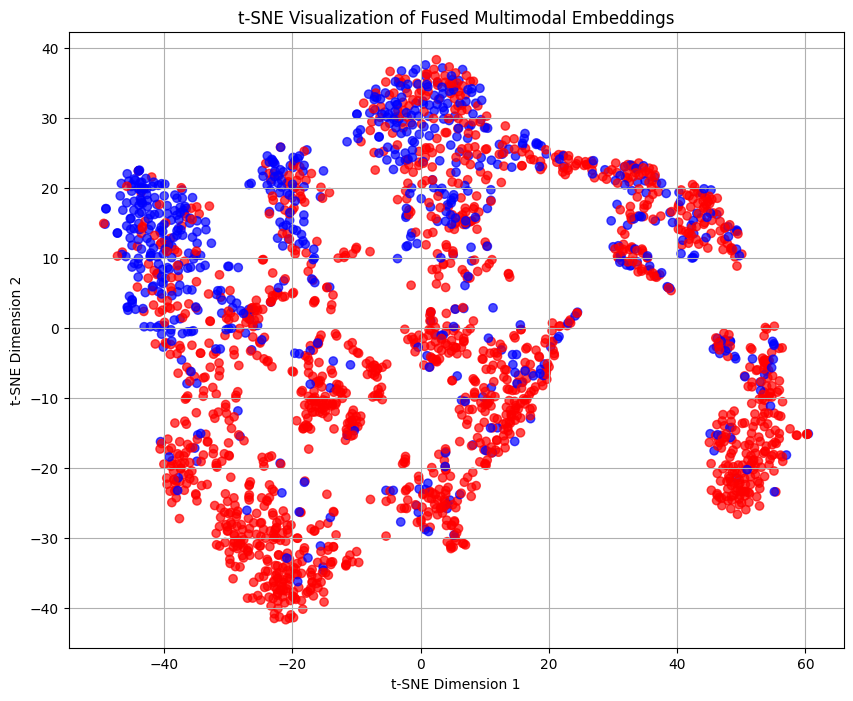

In [3]:
from sklearn.manifold import TSNE
import numpy as np

def extract_fused_embeddings(model, loader, device):
    """
    Extracts the fused embeddings (from gated fusion) for each sample in the loader.
    Returns a tuple (embeddings, labels) where embeddings is an N x D array and labels is an N-array.
    """
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            
            # Get text and image embeddings
            text_outputs = model.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
            text_embeds = text_outputs.pooler_output  # shape: (batch, hidden_size)
            image_outputs = model.image_encoder(pixel_values=images)
            image_embeds = image_outputs.pooler_output  # shape: (batch, hidden_size)
            
            # Compute gated fusion representation
            gate = torch.sigmoid(model.gate_layer(text_embeds + image_embeds))
            fused = gate * text_embeds + (1 - gate) * image_embeds  # shape: (batch, hidden_size)
            
            all_embeddings.append(fused.cpu())
            # Use label_text_image for coloring (you can change this to any other label)
            all_labels.append(batch['label_text_image'])
    
    embeddings = torch.cat(all_embeddings, dim=0).numpy()  # shape: (N, hidden_size)
    labels = torch.cat(all_labels, dim=0).numpy()  # shape: (N,)
    return embeddings, labels

# Extract embeddings on the dev set (you can also run on train set or test set)
embeddings, labels = extract_fused_embeddings(model, dev_loader, device)

# Apply t-SNE to reduce embeddings to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))

# Here, we color the points based on the label_text_image value.
# In our dataset, label_text_image is 1.0 for "Positive" and 0.0 for "Negative".
# We'll assign a color for each label.
colors = ['red' if label == 1.0 else 'blue' for label in labels]

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=colors, alpha=0.7)
plt.title("t-SNE Visualization of Fused Multimodal Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Load and Filter Test Data ---
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'
test_df = pd.read_csv(test_file_path, sep='\t')

# Filter test data to only include rows where label_text_image is "Positive"
test_df = test_df[test_df['label_text_image'] == "Positive"]

# Create test dataset and dataloader using the same CrisisDataset class
test_dataset = CrisisDataset(test_df, tokenizer, image_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def evaluate_model(model, loader, branch, device):
    """
    Evaluate the model on the test loader for a given branch.
    branch can be one of "multimodal", "text", or "image".
    For all test samples, the ground truth is considered positive (1).
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            
            # Ground truth: since test samples are filtered as positive.
            targets = torch.ones(input_ids.size(0), device=device)
            
            multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
            if branch == "multimodal":
                logits = multimodal_logits
            elif branch == "text":
                logits = text_logits
            elif branch == "image":
                logits = image_logits
            else:
                raise ValueError("Invalid branch specified.")
            
            # Apply sigmoid and threshold at 0.5
            probs = torch.sigmoid(logits).squeeze().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.extend(preds.tolist())
            all_targets.extend(targets.cpu().numpy().tolist())
    
    # Compute metrics using sklearn
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    
    return accuracy, precision, recall, f1

# Evaluate all three branches
for branch in ["multimodal", "text", "image"]:
    acc, prec, rec, f1 = evaluate_model(model, test_loader, branch, device)
    print(f"Results for {branch.capitalize()} Branch:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}\n")


c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Results for Multimodal Branch:
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1 Score : 1.0000



c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Results for Text Branch:
  Accuracy : 0.7425
  Precision: 1.0000
  Recall   : 0.7425
  F1 Score : 0.8522



c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Results for Image Branch:
  Accuracy : 0.5737
  Precision: 1.0000
  Recall   : 0.5737
  F1 Score : 0.7291



In [6]:
import os
import torch

# Define the save directory and file name
save_dir = r"D:\BTP_2\CrisisMMD_v2.0\model\Model_VIT_BERT_multimodel"
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist
model_save_path = os.path.join(save_dir, "model_weights.pth")

# Save the model weights
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")


Model weights saved to D:\BTP_2\CrisisMMD_v2.0\model\Model_VIT_BERT_multimodel\model_weights.pth


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Load and Filter Test Data ---
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'
test_df = pd.read_csv(test_file_path, sep='\t')

# Filter test data to only include rows where label_text_image is "Positive"
test_df = test_df[test_df['label_text_image'] == "Negative"]

# Create test dataset and dataloader using the same CrisisDataset class
test_dataset = CrisisDataset(test_df, tokenizer, image_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def evaluate_model(model, loader, branch, device):
    """
    Evaluate the model on the test loader for a given branch.
    branch can be one of "multimodal", "text", or "image".
    For all test samples, the ground truth is considered positive (1).
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            
            # Ground truth: since test samples are filtered as positive.
            targets = torch.ones(input_ids.size(0), device=device)
            
            multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
            if branch == "multimodal":
                logits = multimodal_logits
            elif branch == "text":
                logits = text_logits
            elif branch == "image":
                logits = image_logits
            else:
                raise ValueError("Invalid branch specified.")
            
            # Apply sigmoid and threshold at 0.5
            probs = torch.sigmoid(logits).squeeze().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.extend(preds.tolist())
            all_targets.extend(targets.cpu().numpy().tolist())
    
    # Compute metrics using sklearn
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    
    return accuracy, precision, recall, f1

# Evaluate all three branches
for branch in ["multimodal", "text", "image"]:
    acc, prec, rec, f1 = evaluate_model(model, test_loader, branch, device)
    print(f"Results for {branch.capitalize()} Branch:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}\n")


Results for Multimodal Branch:
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1 Score : 1.0000

Results for Text Branch:
  Accuracy : 0.8293
  Precision: 1.0000
  Recall   : 0.8293
  F1 Score : 0.9067

Results for Image Branch:
  Accuracy : 0.2617
  Precision: 1.0000
  Recall   : 0.2617
  F1 Score : 0.4149



In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Load and Filter Test Data ---
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'
test_df = pd.read_csv(test_file_path, sep='\t')

# Filter test data to only include rows where label_text_image is "Positive"
# test_df = test_df[test_df['label_text_image'] == "Positive"]

# Create test dataset and dataloader using the same CrisisDataset class
test_dataset = CrisisDataset(test_df, tokenizer, image_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def evaluate_model(model, loader, branch, device):
    """
    Evaluate the model on the test loader for a given branch.
    branch can be one of "multimodal", "text", or "image".
    For all test samples, the ground truth is considered positive (1).
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            
            # Ground truth: since test samples are filtered as positive.
            targets = torch.ones(input_ids.size(0), device=device)
            
            multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
            if branch == "multimodal":
                logits = multimodal_logits
            elif branch == "text":
                logits = text_logits
            elif branch == "image":
                logits = image_logits
            else:
                raise ValueError("Invalid branch specified.")
            
            # Apply sigmoid and threshold at 0.5
            probs = torch.sigmoid(logits).squeeze().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.extend(preds.tolist())
            all_targets.extend(targets.cpu().numpy().tolist())
    
    # Compute metrics using sklearn
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    
    return accuracy, precision, recall, f1

# Evaluate all three branches
for branch in ["multimodal", "text", "image"]:
    acc, prec, rec, f1 = evaluate_model(model, test_loader, branch, device)
    print(f"Results for {branch.capitalize()} Branch:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}\n")


c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Results for Multimodal Branch:
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1 Score : 1.0000



c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Results for Text Branch:
  Accuracy : 0.7698
  Precision: 1.0000
  Recall   : 0.7698
  F1 Score : 0.8699



c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Results for Image Branch:
  Accuracy : 0.4756
  Precision: 1.0000
  Recall   : 0.4756
  F1 Score : 0.6447

